# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays

# Modelling
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsforecast.models import AutoARIMA, ARIMA
from statsforecast.utils import AirPassengers as ap

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv("../0_data/preprocessed/df_final.csv", try_parse_dates=True)


df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-01-01 00:00:00,6.9844e6,-1.4965,94.97623,-2.1965,-4.269863,0.1,0.0,0.07,0.06,57.899998,2.2768397,3.8268526,161.56496,228.81418,8.28,-0.7965,0.2535,3.2535,8.3535,0.477,0.468,0.47,0.47,0.0,-0.496,95.016594,-1.196,-3.113932,0.4,0.1,0.21,0.29,95.7,2.16,3.8939953,270.0,…,4.198285,8.350138,149.03632,172.56868,11.879999,1.0435,1.6435,4.0435004,7.3435,0.368,0.375,0.392,0.405,0.0,0.0005,95.03646,-0.6995,-2.498038,0.3,0.1,0.14,0.05,91.8,1.835647,4.896529,168.69011,162.89719,7.2,-0.5495,0.4505,2.9505,7.2505,0.4,0.376,0.406,0.41,0.0
2009-01-01 01:00:00,6.7564e6,-1.8465,94.96198,-2.5465,-4.892221,0.0,0.0,0.07,0.06,78.3,3.8268526,8.049845,221.18582,259.69522,9.0,-0.7965,0.2535,3.2535,8.3535,0.475,0.468,0.47,0.47,0.0,-1.046,94.99447,-1.746,-3.901534,0.2,0.1,0.07,0.29,64.799995,3.2599385,8.350138,263.6599,…,4.6800003,6.8399997,157.3801,180.0,11.159999,1.0435,1.6435,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.0495,95.381744,-0.6995,-2.496816,0.2,0.1,0.07,0.05,99.899994,1.484318,3.0547013,284.03625,224.9999,8.28,-0.5495,0.4505,2.9005,7.2505,0.399,0.376,0.406,0.41,0.0
2009-01-01 02:00:00,6.5171e6,-1.2965,96.03991,-1.8465,-4.322661,0.0,0.0,0.07,0.06,50.100002,4.3349743,9.826088,228.36655,261.57312,9.36,-0.7965,0.2535,3.2535,8.3535,0.473,0.468,0.47,0.47,0.0,-0.846,94.6542,-1.596,-3.819829,0.0,0.0,0.07,0.29,72.6,4.2136917,10.365251,289.9832,…,2.968636,6.297428,194.03627,210.96368,10.799999,1.0935,1.6935,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.3495,95.02247,-1.0495,-2.914122,0.3,0.1,0.14,0.06,99.9,1.9386592,5.0142193,291.80148,291.03757,8.64,-0.5495,0.4505,2.9005,7.2005,0.398,0.377,0.406,0.41,0.0
2009-01-01 03:00:00,6.2269e6,-1.1465,96.398476,-1.6465,-4.080796,0.0,0.0,0.07,0.06,69.3,3.8939953,8.766573,213.6901,250.82089,9.36,-0.7965,0.2535,3.2535,8.3535,0.472,0.468,0.47,0.47,0.0,-0.846,93.616,-1.746,-3.721354,0.0,0.0,0.0,0.29,58.499996,3.396233,10.086427,302.00534,…,3.2599385,5.991594,1

In [3]:
df.shape

(137328, 163)

In [4]:
df

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2009-01-01 00:00:00,6.9844e6,-1.4965,94.97623,-2.1965,-4.269863,0.1,0.0,0.07,0.06,57.899998,2.2768397,3.8268526,161.56496,228.81418,8.28,-0.7965,0.2535,3.2535,8.3535,0.477,0.468,0.47,0.47,0.0,-0.496,95.016594,-1.196,-3.113932,0.4,0.1,0.21,0.29,95.7,2.16,3.8939953,270.0,…,4.198285,8.350138,149.03632,172.56868,11.879999,1.0435,1.6435,4.0435004,7.3435,0.368,0.375,0.392,0.405,0.0,0.0005,95.03646,-0.6995,-2.498038,0.3,0.1,0.14,0.05,91.8,1.835647,4.896529,168.69011,162.89719,7.2,-0.5495,0.4505,2.9505,7.2505,0.4,0.376,0.406,0.41,0.0
2009-01-01 01:00:00,6.7564e6,-1.8465,94.96198,-2.5465,-4.892221,0.0,0.0,0.07,0.06,78.3,3.8268526,8.049845,221.18582,259.69522,9.0,-0.7965,0.2535,3.2535,8.3535,0.475,0.468,0.47,0.47,0.0,-1.046,94.99447,-1.746,-3.901534,0.2,0.1,0.07,0.29,64.799995,3.2599385,8.350138,263.6599,…,4.6800003,6.8399997,157.3801,180.0,11.159999,1.0435,1.6435,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.0495,95.381744,-0.6995,-2.496816,0.2,0.1,0.07,0.05,99.899994,1.484318,3.0547013,284.03625,224.9999,8.28,-0.5495,0.4505,2.9005,7.2505,0.399,0.376,0.406,0.41,0.0
2009-01-01 02:00:00,6.5171e6,-1.2965,96.03991,-1.8465,-4.322661,0.0,0.0,0.07,0.06,50.100002,4.3349743,9.826088,228.36655,261.57312,9.36,-0.7965,0.2535,3.2535,8.3535,0.473,0.468,0.47,0.47,0.0,-0.846,94.6542,-1.596,-3.819829,0.0,0.0,0.07,0.29,72.6,4.2136917,10.365251,289.9832,…,2.968636,6.297428,194.03627,210.96368,10.799999,1.0935,1.6935,4.0435004,7.3435,0.367,0.375,0.391,0.405,0.0,-0.3495,95.02247,-1.0495,-2.914122,0.3,0.1,0.14,0.06,99.9,1.9386592,5.0142193,291.80148,291.03757,8.64,-0.5495,0.4505,2.9005,7.2005,0.398,0.377,0.406,0.41,0.0
2009-01-01 03:00:00,6.2269e6,-1.1465,96.398476,-1.6465,-4.080796,0.0,0.0,0.07,0.06,69.3,3.8939953,8.766573,213.6901,250.82089,9.36,-0.7965,0.2535,3.2535,8.3535,0.472,0.468,0.47,0.47,0.0,-0.846,93.616,-1.746,-3.721354,0.0,0.0,0.0,0.29,58.499996,3.396233,10.086427,302.00534,…,3.2599385,5.991594,1

# Missing values

Just forward fill for now.

In [5]:
df = df.fill_null(strategy="forward")

# Lags

Include target variable lags.

- Same hour on previous day
- Average consumption during the past week

In [6]:
lags_24h = (
    df.select("datetime", "kWh")
    .with_columns(pl.col("datetime").dt.offset_by("1d"))
    .rename({"kWh": "kWh_lag_24"})
)

In [7]:
lags_rolling_1w = (
    df.select("datetime", "kWh")
    .with_columns(pl.col("kWh").rolling_mean(window_size=24 * 7))
    .with_columns(pl.col("datetime").dt.offset_by("1d"))
    .rename({"kWh": "kWh_rolling_1w"})
)

In [8]:
df = df.join(lags_24h, how="left", on="datetime", coalesce=True).join(
    lags_rolling_1w, how="left", on="datetime", coalesce=True
)

In [9]:
df = df.filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

# Calendar Features

In [10]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    is_weekend=pl.col("datetime").dt.weekday().is_in([6, 7]).cast(pl.Int32),
    week_of_month=(pl.col("datetime").dt.day() - 1) // 7 + 1,
    week_of_year=pl.col("datetime").dt.week(),
    month=pl.col("datetime").dt.month(),
    quarter=pl.col("datetime").dt.quarter(),
    hour=pl.col("datetime").dt.hour(),
    is_morning=pl.col("datetime").dt.hour().is_between(6, 11).cast(pl.Int32),
    is_afternoon=pl.col("datetime").dt.hour().is_between(12, 17).cast(pl.Int32),
    is_evening=pl.col("datetime").dt.hour().is_between(18, 23).cast(pl.Int32),
    is_night=(pl.col("datetime").dt.hour().is_between(0, 5)).cast(pl.Int32),
)

## Holidays

In [11]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

In [12]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df.head()

holiday_name,holiday_date
str,date
"""Neujahrestag""",2021-01-01
"""Berchtoldstag""",2021-01-02
"""Karfreitag""",2021-04-02
"""Ostermontag""",2021-04-05
"""Tag der Arbeit""",2021-05-01


In [13]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
)

df.head()

datetime,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,…,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation,kWh_lag_24,kWh_rolling_1w,day_of_month,day_of_year,day_of_week,is_weekend,week_of_month,week_of_year,month,quarter,hour,is_morning,is_afternoon,is_evening,is_night,holiday_name
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i16,i8,i32,i8,i8,i8,i8,i8,i32,i32,i32,i32,str
2021-09-01 00:00:00,5.1633e6,14.276999,86.62722,12.077,14.274088,0.0,0.0,0.0,0.0,23.1,4.452954,8.0899935,14.036275,57.724377,10.440001,15.377,17.077002,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.794499,91.742035,10.494499,10.801474,0.0,0.0,0.0,0.0,1.5,7.9036193,20.140705,59.93151,…,11.392,12.423903,0.0,0.0,0.0,0.0,4.2000003,8.217153,20.111729,28.810698,45.72514,20.519999,14.542001,16.042,16.142,15.642,0.382,0.375,0.359,0.394,0.0,5.1374e6,5.7676e6,1,244,3,0,1,35,9,3,0,0,0,0,1,null
2021-09-01 01:00:00,5.0777e6,13.177,91.223816,11.776999,13.115568,0.0,0.0,0.0,0.0,10.800001,4.198285,5.6233797,329.03632,39.805527,7.5599995,14.776999,16.977001,16.877,15.177,0.381,0.365,0.401,0.446,0.0,11.294499,92.32622,10.0945,10.245484,0.0,0.0,0.0,0.0,0.9,7.491114,19.770523,54.782326,…,11.442,11.601958,0.0,0.0,0.0,0.0,0.6,10.1887,23.233252,32.005356,40.601215,24.119999,14.192,15.892,16.142,15.642,0.381,0.375,0.359,0.394,0.0,5.0358e6,5.7685e6,1,244,3,0,1,35,9,3,1,0,0,0,1,null
2021-09-01 02:00:00,4.9315e6,13.377,88.56768,11.526999,13.566463,0.0,0.0,0.0,0.0,6.6000004,1.9386592,6.830519,21.801476,71.564964,6.8399997,14.627,16.977001,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.3945,91.10575,9.994499,10.04735,0.0,0.0,0.0,0.0,3.9,9.339208,21.578989,62.447273,…,11.442,11.363569,0.0,0.0,0.0,0.0,1.8000001,11.480557,23.469128,41.185825,48.731503,24.84,14.742001,16.042,16.142,15.642,0.378,0.374,0.358,0.394,0.0,4.9524e6,5.7694e6,1,244,3,0,1,35,9,3,2,0,0,0,1,null
2021-09-01 03:00:00,4.7878e6,13.077,89.72258,11.427,13.146872,0.0,0.0,0.0,0.0,0.6,2.5455842,2.7416782,278.13,23.198618,5.04,14.026999,16.827002,16.877,15.177,0.378,0.363,0.399,0.446,0.0,11.1945,92.320404,9.994499,9.884285,0.0,0.0,0.0,0.0,8.099999,9.085988,20.140705,56.3099,…,11.092,11.280403,0.0,0.0,0.0,0.0,2.1,8.913181,21.175837,43.36347,54.688713,26.64,14.242001,15.942,16.142,15.642,0.377,0.374,0.358,0.394,0.0,4.7984e6,5.7704e6,1,244,3,0,1,35,9,3,3,0,0,0,1,null
2021-09-01 04:00:00,4.7038e6,10.677,96.7212,10.177,9.91409,0.0,0.0,0.0,0.0,0.0,5.6920996,3.8773184,288.43503,338.19852,7.5599995,13.477,16.677,16.877,15.177,0.378,0.363,0.399,0.446,0.0,10.794499,94.804436,9.994499,9.324408,0.0,0

# Cyclical Encoding

In [14]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [15]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    "day_of_week": 7,
    "week_of_month": 4,
    "week_of_year": 52,
    "month": 12,
    "quarter": 4,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [16]:
cat_cols = ["holiday_name"]

num_cols = df.select(
    cs.contains(
        "temperature_2m",
        "relative_humidity_2m",
        "dew_point_2m",
        "apparent_temperature",
        "precipitation",
        "rain",
        "snowfall",
        "snow_depth",
        "cloud_cover",
        "wind_speed_10m",
        "wind_speed_100m",
        "wind_direction_10m",
        "wind_direction_100m",
        "wind_gusts_10m",
        "soil_temperature_0_to_7cm",
        "soil_temperature_7_to_28cm",
        "soil_temperature_28_to_100cm",
        "soil_temperature_100_to_255cm",
        "soil_moisture_0_to_7cm",
        "soil_moisture_7_to_28cm",
        "soil_moisture_28_to_100cm",
        "soil_moisture_100_to_255cm",
        "shortwave_radiation",
    )
).columns + ["kWh_lag_24", "kWh_rolling_1w"]

manual_cols = df.select(pl.selectors.contains("_cos", "_sin", "is_")).columns

In [17]:
df.drop(manual_cols + cat_cols + num_cols)

datetime,kWh
datetime[μs],f64
2021-09-01 00:00:00,5.1633e6
2021-09-01 01:00:00,5.0777e6
2021-09-01 02:00:00,4.9315e6
2021-09-01 03:00:00,4.7878e6
2021-09-01 04:00:00,4.7038e6
…,…
2024-08-31 19:00:00,5.3614e6
2024-08-31 20:00:00,5.3775e6
2024-08-31 21:00:00,5.2130e6


In [18]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [19]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

# Hyperparameter Tuning

In [21]:
df_full = (
    df.to_pandas()
    .assign(datetime=lambda x: x.datetime.astype("datetime64[ns]"))
    .set_index("datetime")
    .asfreq("h")
    .sort_index()
)
df_full.head()

,kWh,Basel_temperature_2m,Basel_relative_humidity_2m,Basel_dew_point_2m,Basel_apparent_temperature,Basel_precipitation,Basel_rain,Basel_snowfall,Basel_snow_depth,Basel_cloud_cover,Basel_wind_speed_10m,Basel_wind_speed_100m,Basel_wind_direction_10m,Basel_wind_direction_100m,Basel_wind_gusts_10m,Basel_soil_temperature_0_to_7cm,Basel_soil_temperature_7_to_28cm,Basel_soil_temperature_28_to_100cm,Basel_soil_temperature_100_to_255cm,Basel_soil_moisture_0_to_7cm,Basel_soil_moisture_7_to_28cm,Basel_soil_moisture_28_to_100cm,Basel_soil_moisture_100_to_255cm,Basel_shortwave_radiation,Bern_temperature_2m,Bern_relative_humidity_2m,Bern_dew_point_2m,Bern_apparent_temperature,Bern_precipitation,Bern_rain,Bern_snowfall,Bern_snow_depth,Bern_cloud_cover,Bern_wind_speed_10m,Bern_wind_speed_100m,Bern_wind_direction_10m,Bern_wind_direction_100m,Bern_wind_gusts_10m,Bern_soil_temperature_0_to_7cm,Bern_soil_temperature_7_to_28cm,Bern_soil_temperature_28_to_100cm,Bern_soil_temperature_100_to_255cm,Bern_soil_moisture_0_to_7cm,Bern_soil_moisture_7_to_28cm,Bern_soil_moisture_28_to_100cm,Bern_soil_moisture_100_to_255cm,Bern_shortwave_radiation,Geneva_temperature_2m,Geneva_relative_humidity_2m,Geneva_dew_point_2m,Geneva_apparent_temperature,Geneva_precipitation,Geneva_rain,Geneva_snowfall,Geneva_snow_depth,Geneva_cloud_cover,Geneva_wind_speed_10m,Geneva_wind_speed_100m,Geneva_wind_direction_10m,Geneva_wind_direction_100m,Geneva_wind_gusts_10m,Geneva_soil_temperature_0_to_7cm,Geneva_soil_temperature_7_to_28cm,Geneva_soil_temperature_28_to_100cm,Geneva_soil_temperature_100_to_255cm,Geneva_soil_moisture_0_to_7cm,Geneva_soil_moisture_7_to_28cm,Geneva_soil_moisture_28_to_100cm,Geneva_soil_moisture_100_to_255cm,Geneva_shortwave_radiation,Lugano_temperature_2m,Lugano_relative_humidity_2m,Lugano_dew_point_2m,Lugano_apparent_temperature,Lugano_precipitation,Lugano_rain,Lugano_snowfall,Lugano_snow_depth,Lugano_cloud_cover,Lugano_wind_speed_10m,Lugano_wind_speed_100m,Lugano_wind_direction_10m,Lugano_wind_direction_100m,Lugano_wind_gusts_10m,Lugano_soil_temperature_0_to_7cm,Lugano_soil_temperature_7_to_28cm,Lugano_soil_temperature_28_to_100cm,Lugano_soil_temperature_100_to_255cm,Lugano_soil_moisture_0_to_7cm,Lugano_soil_moisture_7_to_28cm,Lugano_soil_moisture_28_to_100cm,Lugano_soil_moisture_100_to_255cm,Lugano_shortwave_radiation,Sion_temperature_2m,Sion_relative_humidity_2m,Sion_dew_point_2m,Sion_apparent_temperature,Sion_precipitation,Sion_rain,Sion_snowfall,Sion_snow_depth,Sion_cloud_cover,Sion_wind_speed_10m,Sion_wind_speed_100m,Sion_wind_direction_10m,Sion_wind_direction_100m,Sion_wind_gusts_10m,Sion_soil_temperature_0_to_7cm,Sion_soil_temperature_7_to_28cm,Sion_soil_temperature_28_to_100cm,Sion_soil_temperature_100_to_255cm,Sion_soil_moisture_0_to_7cm,Sion_soil_moisture_7_to_28cm,Sion_soil_moisture_28_to_100cm,Sion_soil_moisture_100_to_255cm,Sion_shortwave_radiation,St_temperature_2m,St_relative_humidity_2m,St_dew_point_2m,St_apparent_temperature,St_precipitation,St_rain,St_snowfall,St_snow_depth,St_cloud_cover,St_wind_speed_10m,St_wind_speed_100m,St_wind_direction_10m,St_wind_direction_100m,St_wind_gusts_10m,St_soil_temperature_0_to_7cm,St_soil_temperature_7_to_28cm,St_soil_temperature_28_to_100cm,St_soil_temperature_100_to_255cm,St_soil_moisture_0_to_7cm,St_soil_moisture_7_to_28cm,St_soil_moisture_28_to_100cm,St_soil_moisture_100_to_255cm,St_shortwave_radiation,Zurich_temperature_2m,Zurich_relative_humidity_2m,Zurich_dew_point_2m,Zurich_apparent_temperature,Zurich_precipitation,Zurich_rain,Zurich_snowfall,Zurich_snow_depth,Zurich_cloud_cover,Zurich_wind_speed_10m,Zurich_wind_speed_100m,Zurich_wind_direction_10m,Zurich_wind_direction_100m,Zurich_wind_gusts_10m,Zurich_soil_temperature_0_to_7cm,Zurich_soil_temperature_7_to_28cm,Zurich_soil_temperature_28_to_100cm,Zurich_soil_temperature_100_to_255cm,Zurich_soil_moisture_0_to_7cm,Zurich_soil_moisture_7_to_28cm,Zurich_soil_moisture_28_to_100cm,Zurich_soil_moisture_100_to_255cm,Zurich_shortwave_radiation,kWh_lag_2

In [22]:
# Go a lot smaller on the data to make computation feasible
df_train_val = df_full["2021-09-01":"2023-08-31"]
# df_val = df_full["2022-07-01":"2023-07-31"]

In [23]:
tscv = TimeSeriesSplit(n_splits=5, max_train_size=365 * 24, test_size=int(365 * 24 / 5))

target_splits = []

X_train_preprocessed_list = []
X_val_preprocessed_list = []
y_train_list = []
y_val_list = []

for split_idx, (train_index, val_index) in enumerate(tscv.split(df_train_val)):

    # Create X splits
    X_train = df_train_val.iloc[train_index].drop(columns="kWh")
    X_val = df_train_val.iloc[val_index].drop(columns="kWh")

    X_train_preprocessed = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out(),
    )
    X_train_preprocessed_list.append(X_train_preprocessed)

    X_val_preprocessed = pd.DataFrame(
        preprocessor.transform(X_val),
        columns=preprocessor.get_feature_names_out(),
    )
    X_val_preprocessed_list.append(X_val_preprocessed)

    # Create y splits
    y_train = df_train_val.iloc[train_index]["kWh"]
    y_train_list.append(y_train)

    y_val = df_train_val.iloc[val_index]["kWh"]
    y_val_list.append(y_val)

    # Create dataframe for plotting the TimeSeries CV
    target_split = pd.concat(
        [
            y_train.reset_index().assign(Period="Training"),
            y_val.reset_index().assign(Period="Validation"),
        ]
    ).assign(split=split_idx + 1)

    target_splits.append(target_split)

matplotlib.font_manager INFO  Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


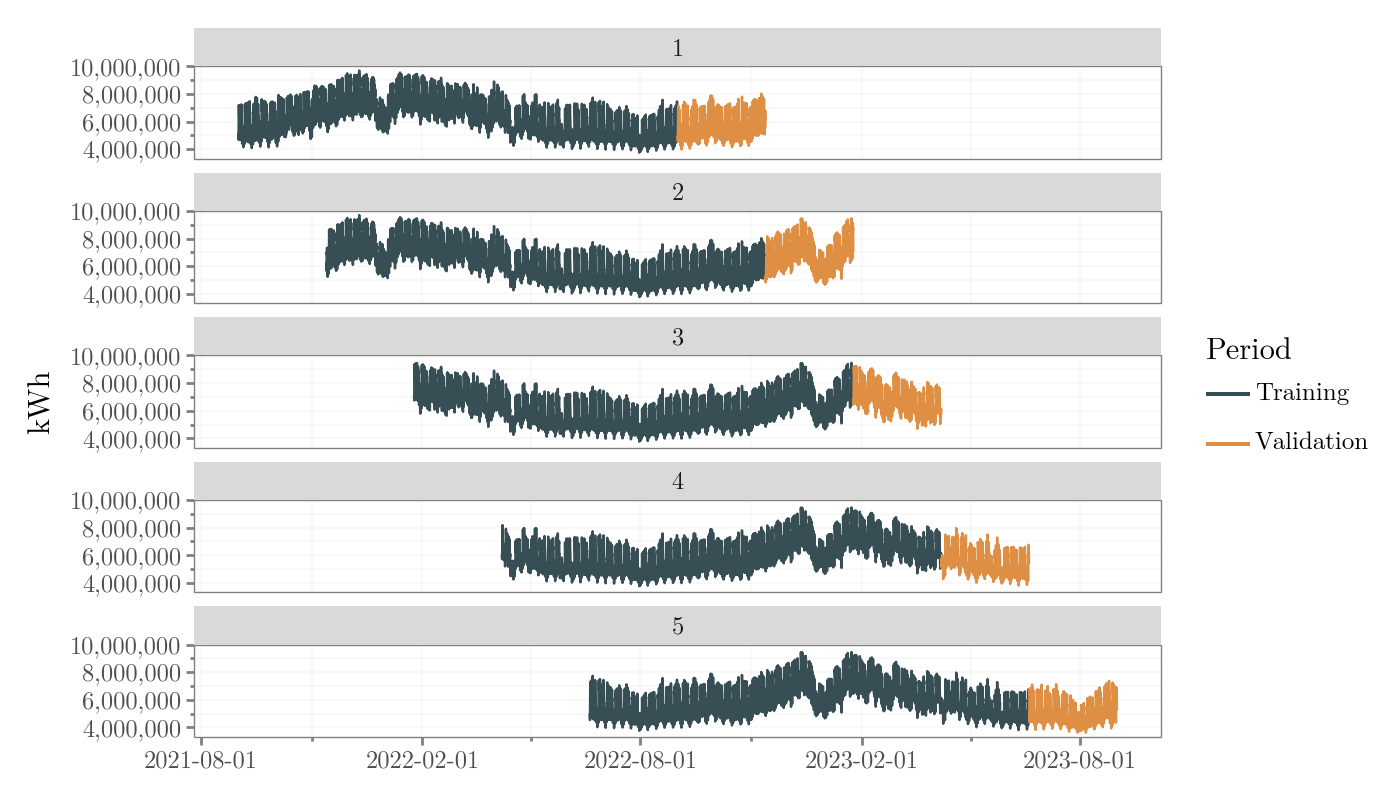

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/ridge_cv_splits.pdf
matplotlib.font_manager INFO  Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [27]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(
        data=pd.concat(target_splits),
        mapping=pn.aes(x="datetime", y="kWh", colour="Period"),
    )
    + pn.geom_line()
    + pn.facet_wrap("~ split", ncol=1)
    + pn.scale_colour_manual(values=jama_colour)
    + pn.scale_y_continuous(labels=comma_format())
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height), axis_title_x=pn.element_blank())
)

display(fig)

fig.save(
    filename="../1_figures/ridge_cv_splits.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

## Manually Fitting a Model

In [25]:
y_preds = []

for split_idx in range(tscv.get_n_splits()):

    # Fit the model
    model = Ridge()
    model.fit(X=X_train_preprocessed_list[split_idx], y=y_train_list[split_idx])

    # Make predictions
    y_pred = model.predict(X=X_val_preprocessed_list[split_idx])
    y_preds.append(y_pred)

    # Calculate loss
    loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val_list[split_idx])

y_preds_val = (
    pd.concat(target_splits)
    .query("Period == 'Validation'")
    .assign(pred=np.vstack(y_preds).flatten())
)

In [26]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

## RayTune Tuning Setup

Repeat the same as manual fit (train/val split), but do order selection via OptunaSearch

In [27]:
def ridge_trainable(config):

    try:
        cv_losses = np.array([])

        for split_idx in range(tscv.get_n_splits()):

            # Fit the model
            model = Ridge(alpha=config["alpha"])
            model.fit(X=X_train_preprocessed_list[split_idx], y=y_train_list[split_idx])

            # Make predictions
            y_pred = model.predict(X=X_val_preprocessed_list[split_idx])

            # Calculate loss
            loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val_list[split_idx])
            cv_losses = np.append(cv_losses, loss)

        train.report({"loss": np.mean(cv_losses)})

    except Exception as e:
        print(f"An error occurred: {e}")  # Print error message for debugging
        tune.report(metric=float("inf"))

In [28]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    ridge_trainable,
    config={"alpha": tune.loguniform(1e-4, 1000)},
    metric="loss",
    mode="min",
    name="Ridge",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 15,
    num_samples=-1,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

2024-11-02 18:50:36,224	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-02 18:50:38,963	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-02 18:50:38,967	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2024-11-02 18:50:39,603] A new study created in memory with name: optuna


(raylet) Warning: The actor ImplicitFunc is very large (79 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial name,loss
ridge_trainable_00ad5c98,458626
ridge_trainable_00c9e428,414905
ridge_trainable_01322955,419357
ridge_trainable_02f058dd,444808
ridge_trainable_03561aa3,442618
ridge_trainable_046cd95d,606845
ridge_trainable_0523d601,415910
ridge_trainable_07c2fe9f,422138
ridge_trainable_0c01c3d3,439980
ridge_trainable_1102e355,475072


2024-11-02 19:05:45,724	INFO timeout.py:54 -- Reached timeout of 900 seconds. Stopping all trials.
2024-11-02 19:05:45,924	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/mathi/ray_results/Ridge' in 0.1962s.
2024-11-02 19:05:45,967	INFO tune.py:1041 -- Total run time: 907.00 seconds (902.29 seconds for the tuning loop).
2024-11-02 19:05:47,296	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- ridge_trainable_ce7e19bd: FileNotFoundError('Could not fetch metrics for ridge_trainable_ce7e19bd: both result.json and progress.csv were not found at C:/Users/mathi/ray_results/Ridge/ridge_trainable_ce7e19bd')


In [29]:
analysis.dataframe().to_csv("5_RIDGE_trials.csv", index=False)

# Validation Performance of the Best Model

In [28]:
trials_df = pl.read_csv("5_RIDGE_trials.csv")

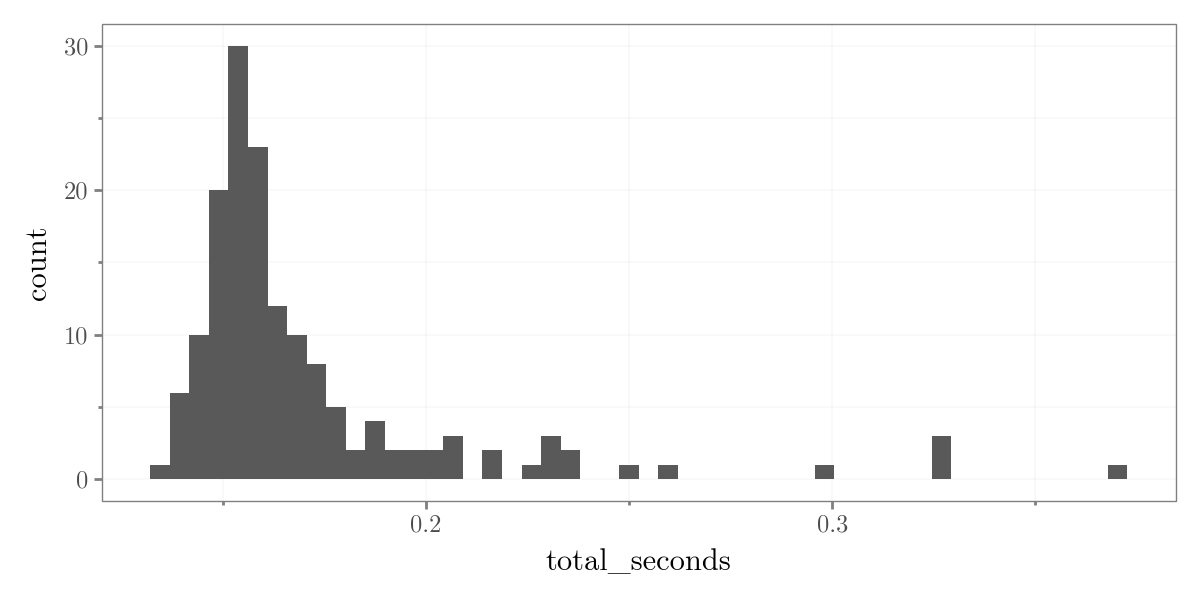

In [29]:
(
    pn.ggplot(
        data=(trials_df.with_columns(total_seconds=pl.col("time_total_s"))),
        mapping=pn.aes("total_seconds"),
    )
    + pn.geom_histogram(bins=50)
    + theme_academic
    + pn.theme(figure_size=(6, 3))
)

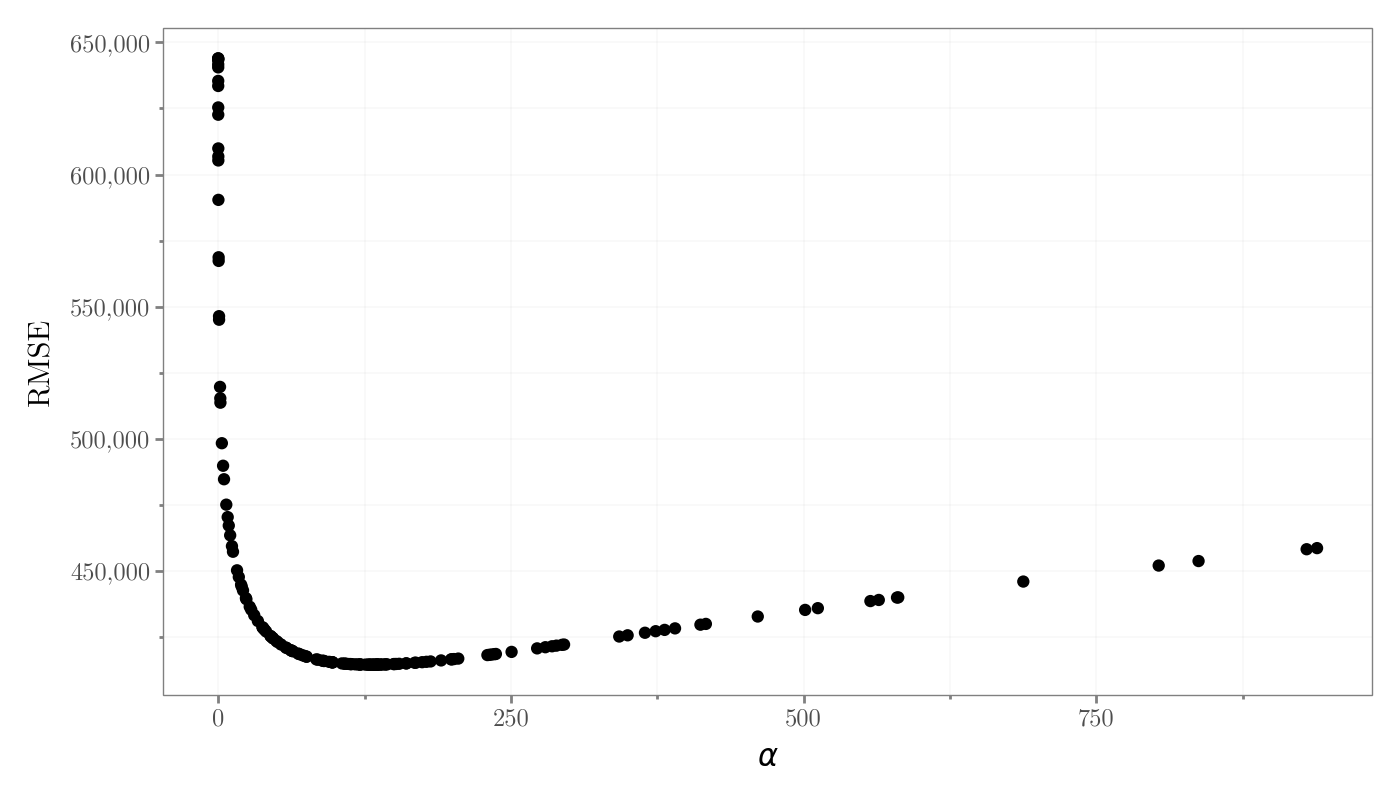

c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\mathi\miniconda3\envs\lapro\lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: ../1_figures/ridge_alpha_loss.pdf


In [34]:
plot_width = 7
plot_height = 4

fig = (
    pn.ggplot(data=trials_df, mapping=pn.aes("config/alpha", "loss"))
    + pn.geom_point()
    + pn.scale_y_continuous(labels=comma_format())
    + pn.labs(y="RMSE", x="$\\alpha$")
    # + pn.geom_smooth(size=0.33, colour="blue")
    + theme_academic
    + pn.theme(figure_size=(plot_width, plot_height))
)

display(fig)

fig.save(
    filename="../1_figures/ridge_alpha_loss.pdf",
    width=plot_width,
    height=plot_height,
    dpi=300,
)

In [33]:
trials_df = pl.read_csv("5_RIDGE_trials.csv")

In [34]:
best_hyperparams_df = (
    trials_df.sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Float64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'alpha': 130.07616275251584}

In [35]:
y_preds = []

for split_idx in range(tscv.get_n_splits()):

    # Fit the model
    model = Ridge(alpha=best_hyperparams["alpha"])
    model.fit(X=X_train_preprocessed_list[split_idx], y=y_train_list[split_idx])

    # Make predictions
    y_pred = model.predict(X=X_val_preprocessed_list[split_idx])
    y_preds.append(y_pred)

    # Calculate loss
    loss = root_mean_squared_error(y_pred=y_pred, y_true=y_val_list[split_idx])

y_preds_val = (
    pd.concat(target_splits)
    .query("Period == 'Validation'")
    .assign(pred=np.vstack(y_preds).flatten())
)

In [36]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    y_preds_val.reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

# Holdout Evaluation

Experimental setup: Weekly retraining on historical data, then predict the entire next week without retraining.

- Training Size: Can set to a long period, as the computational complexity is much lower

In [37]:
trials_df = pl.read_csv("5_RIDGE_trials.csv")

In [38]:
best_hyperparams_df = (
    trials_df.sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(
        pl.col("variable").str.replace("config/", ""), pl.col("value").cast(pl.Float64)
    )
)

best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

best_hyperparams

{'alpha': 130.07616275251584}

In [39]:
df_trainval = df_full["2021-09-01":"2023-08-31"]
df_holdout = df_full["2023-09-01":"2024-08-31"]

In [40]:
df_holdout.reset_index().filter(["datetime"]).assign(
    delta=lambda x: x.datetime - x.datetime.shift(1)
)["delta"].value_counts()

delta
0 days 01:00:00    8783
Name: count, dtype: int64

In [41]:
retraining_freq = 7 * 24
retraining_indices = np.arange(0, df_holdout.shape[0], retraining_freq).tolist()
y_preds = []

for holdout_index in tqdm(retraining_indices):

    # Preprocess training history df
    X_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:].drop(columns=["kWh"]),
            df_holdout.iloc[:holdout_index].drop(columns=["kWh"]),
        ],
        axis=0,
    )
    X_train_preprocessed = pd.DataFrame(
        preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out(),
    )

    X_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq].drop(
        columns=["kWh"]
    )
    X_holdout_preprocessed = pd.DataFrame(
        preprocessor.transform(X_holdout),
        columns=preprocessor.get_feature_names_out(),
    )

    y_train = pd.concat(
        [
            df_trainval.iloc[holdout_index:]["kWh"],
            df_holdout.iloc[:holdout_index]["kWh"],
        ],
        axis=0,
    )
    y_holdout = df_holdout.iloc[holdout_index : holdout_index + retraining_freq]["kWh"]

    # Fit model with best hyperparameters on history (e.g. 1 year)
    model = Ridge(alpha=best_hyperparams["alpha"])
    model = model.fit(X=X_train_preprocessed, y=y_train)

    # Make predictions for that week and store them
    y_pred = pd.DataFrame(
        {"pred": model.predict(X=X_holdout_preprocessed), "kWh": y_holdout}
    )
    y_preds.append(y_pred)

    # Increment holdout index
    holdout_index += retraining_freq

  0%|          | 0/53 [00:00<?, ?it/s]

In [42]:
pd.concat(y_preds).reset_index().to_csv("5_RIDGE_holdout_predictions.csv", index=False)

In [43]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    pd.concat(y_preds).reset_index(),
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Actual vs Predicted Energy Consumption Over Time",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()